# CAB420, Clustering, Example 5: HAC
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we'll look at HAC. HAC does not require us to specify the initial number of clusters, and instead will build a tree that captured the distance between all points. We can then 'truncate' that tree at a level of our choosing, to get the number of clusters.

## Too Long; Didn't Read:
* HAC works a bit differently to K-means and GMMs. It does not need us to specify the number of clusters, and instead computes the pair-wise distance between all points to build a dendrogram that shows how close points are to each other
* We can then partition (i.e. cut) the tree at a point we determine and get a set of clusters out as a result. This means that we can use some criteria based on how far apart we expect points to be to split clusters.
* How we merge clusters in the tree impacts the results of the clustering quite substantially
* The fact that we need to compute the distance between all pairs of points can make HAC prohibitivley expensive for large datasets.

In [2]:
import numpy
# for repeatability
numpy.random.SeedSequence(4)
import sklearn
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import math

## Random Data
To start we're going to create some data. We'll create two noisy clusters and try split them. Note that I've ensured that these clustes overlap a bit, to make it difficult.

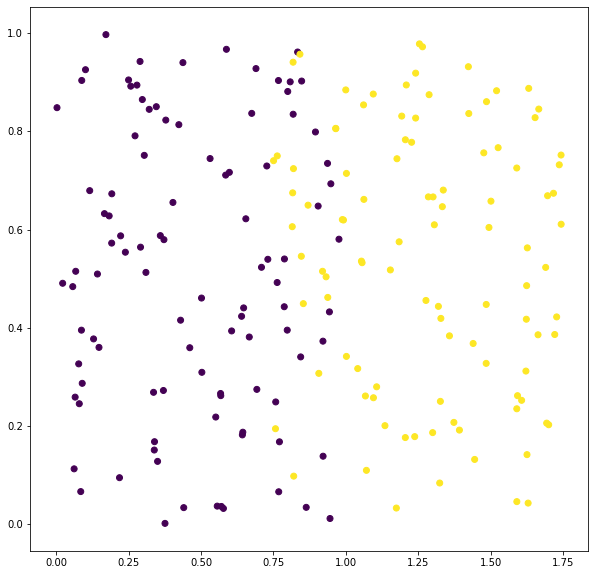

In [3]:
c1 = numpy.random.random((100, 2))
c2 = numpy.random.random((100, 2))
c2[:,0] = c2[:,0]+0.75

X = numpy.concatenate([c1, c2])
Y = numpy.zeros((200))
Y[100:] = 1

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=Y)

## HAC

The python version of HAC that we're going to use differs a little bit from MATLABs (for once, I think I might actually prefer the MATLAB API for this one).

HAC broadly does the following:
* Computes the distance between all pairs of points
* Based on those distances, progressivley merges points based on proximity until all points are merged (i.e we have one cluster)

Different criteria can be used for the distance measure and how to update distances once points are merged. For now, we'll use:
* Euclidean distance
* Complete linkage clustering

This will thus replicate MATLAB, though note that complete is not the default for the clustering approach.

Dendrogram plotting function borrowed from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py).

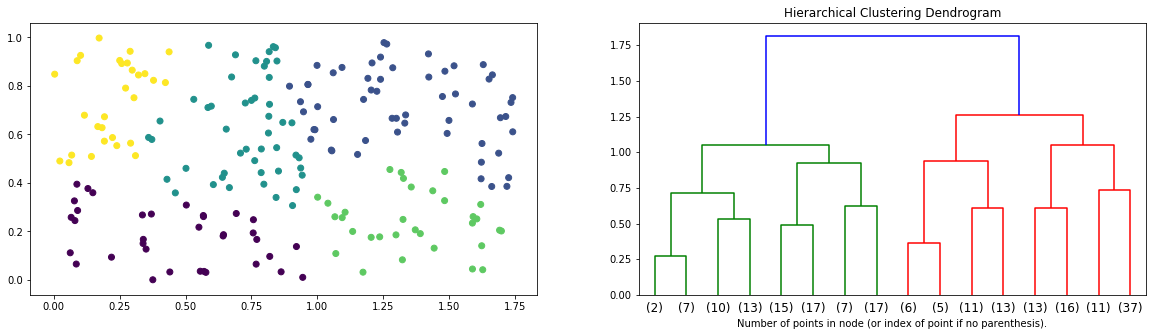

In [4]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
hac = AgglomerativeClustering(distance_threshold=1, n_clusters=None, linkage='complete')
hac = hac.fit(X)

fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hac, truncate_mode='level', p=3)
ax.set_xlabel("Number of points in node (or index of point if no parenthesis).");

At this point, what we see is we have no clusters, though we do have our dendrogram. With sklearn's implementation, we don't have (to my knowledge) a convenient way to partition the dendrogram. Instead we can have a look, and make a decision about how close things shoudl be, or how many clusters we should have.

To actually get some clusters, we need to either:
* Specify a target number of clusters
* Specify a distance threshold at which we stop merging things

Note that with this first option, by default it won't generate the dengrogram. The documentation suggests that we can make it do so with the `compute_full_tree` option, but I can't see to get this to work.

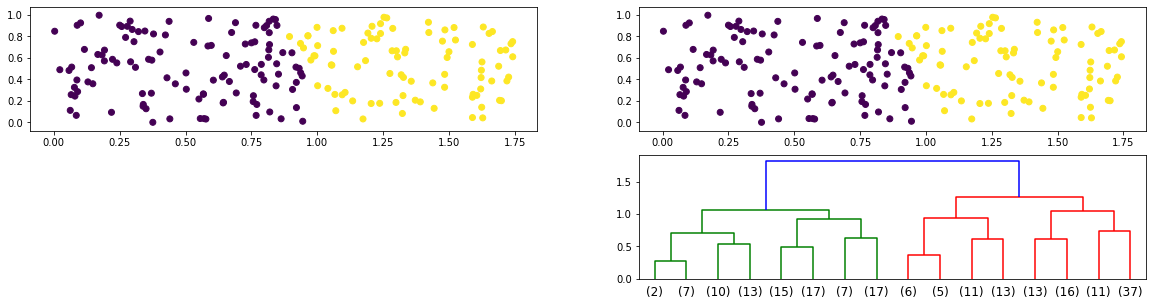

In [5]:
fig = plt.figure(figsize=[20, 5])

hac = AgglomerativeClustering(n_clusters=2, linkage='complete', compute_full_tree=True)
hac = hac.fit(X)
ax = fig.add_subplot(2, 2, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
#ax = fig.add_subplot(2, 2, 3)
#plot_dendrogram(hac, truncate_mode='level', p=3)

hac = AgglomerativeClustering(distance_threshold=1.5, n_clusters=None, linkage='complete', compute_full_tree=True)
hac = hac.fit(X)
ax = fig.add_subplot(2, 2, 2)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax = fig.add_subplot(2, 2, 4)
plot_dendrogram(hac, truncate_mode='level', p=3)

Let's now go with the more interesting data and see what damage we can do.

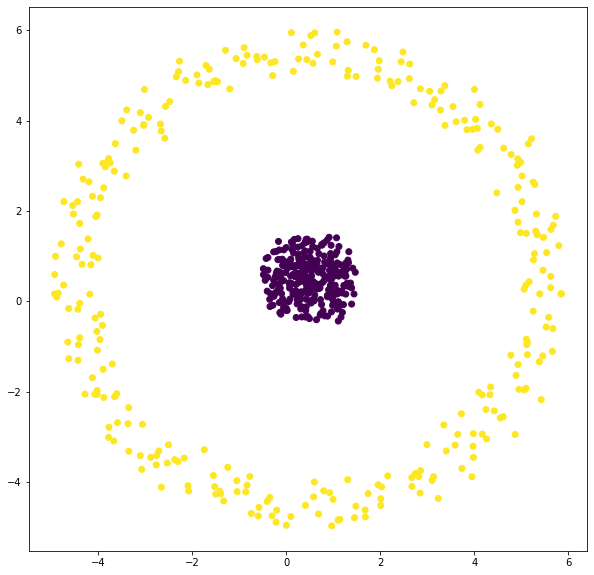

In [6]:
theta = numpy.arange(0, math.pi*2, math.pi*2/300)
theta = numpy.array([numpy.cos(theta), numpy.sin(theta)]).transpose()

c1 = 0.5*theta + numpy.random.random((300,2))
c2 = 5*theta + numpy.random.random((300,2))

X = numpy.concatenate([c1, c2])
Y = numpy.zeros((600))
Y[300:] = 1

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:,0], X[:,1], c=Y);

At this, we'll explore the different linkage criteria. We'll pick a totally arbitraray distance threshold of 4 to give us something to help assess the impact on clustering results.

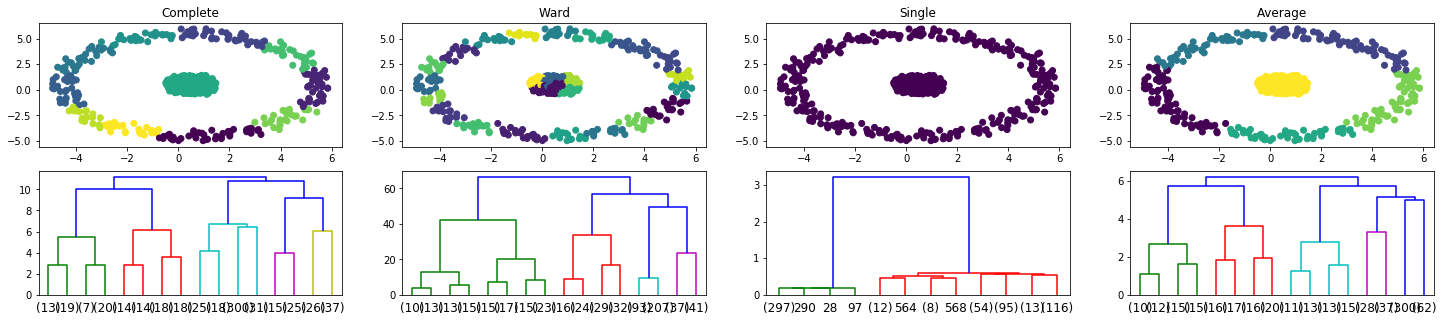

In [7]:
fig = plt.figure(figsize=[25, 5])

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='complete')
hac = hac.fit(X)
ax = fig.add_subplot(2, 4, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Complete')
ax = fig.add_subplot(2, 4, 5)
plot_dendrogram(hac, truncate_mode='level', p=3)

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='ward')
hac = hac.fit(X)
ax = fig.add_subplot(2, 4, 2)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Ward')
ax = fig.add_subplot(2, 4, 6)
plot_dendrogram(hac, truncate_mode='level', p=3)

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='single')
hac = hac.fit(X)
ax = fig.add_subplot(2, 4, 3)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Single')
ax = fig.add_subplot(2, 4, 7)
plot_dendrogram(hac, truncate_mode='level', p=3)

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='average')
hac = hac.fit(X)
ax = fig.add_subplot(2, 4, 4)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Average')
ax = fig.add_subplot(2, 4, 8)
plot_dendrogram(hac, truncate_mode='level', p=3)

That's quite varied. From sklearns help:

> Which linkage criterion to use. The linkage criterion determines which distance to> use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.
> * ward minimizes the variance of the clusters being merged.
> * average uses the average of the distances of each observation of the two sets.
> * complete or maximum linkage uses the maximum distances between all observations of the two sets.
> * single uses the minimum of the distances between all observations of the two sets.

This lines up with what we see:
* Ward, which tries to minimise variance, results in a large number of small compact clusters.
* Complete, which takes the maximum distance between points/clusters, ends up with the next most clusters
* Average, which uses an average distance rather than a max and thus has smaller new distances when merging, results in fewer clusters again
* Single, which takes a more positive approach and uses the minimum distance rather than the maximum, results in just a single cluster

It's worth also considering what happens if we ask for a specific number of clusters rather than a distance threshold.

Text(0.5, 1.0, 'Average')

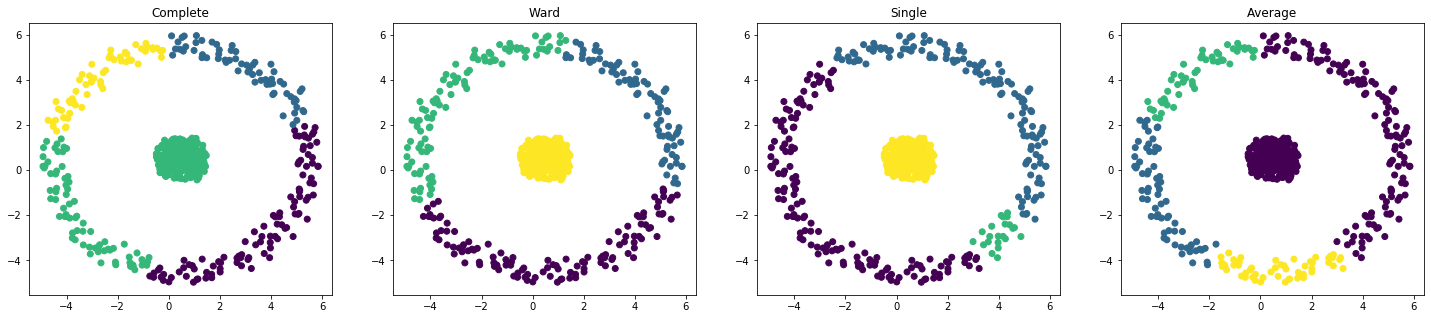

In [8]:
fig = plt.figure(figsize=[25, 5])

hac = AgglomerativeClustering(n_clusters=4, linkage='complete', compute_full_tree=True)
hac = hac.fit(X)
ax = fig.add_subplot(1, 4, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Complete')

hac = AgglomerativeClustering(n_clusters=4, linkage='ward', compute_full_tree=True)
hac = hac.fit(X)
ax = fig.add_subplot(1, 4, 2)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Ward')

hac = AgglomerativeClustering(n_clusters=4, linkage='single', compute_full_tree=True)
hac = hac.fit(X)
ax = fig.add_subplot(1, 4, 3)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Single')

hac = AgglomerativeClustering(n_clusters=4, linkage='average', compute_full_tree=True)
hac = hac.fit(X)
ax = fig.add_subplot(1, 4, 4)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Average')

Again we see variation. It's perhaps harder to discern exactly what each of these mean given the linkage criteria, but:
* With ward, we see three fairly even sized groups (more so than the others), which makes sense given the aim of minimising variance
* Complete and average look similar. These metrics are fairly similar really, so this is not too surprising
* Single, which looks at minimum distance as it's criteria, ends up with the centre ball being one cluster, two clusters in the outer ring, and one point all on it's own. This point is slightly separated from the ring, so is left alone.

Finally, we'll have a quick look at distance measures. We'll do all of these using complete linkage clustering, as ward imposes some limitations on what we can use. Note that we will not consider the precomputed option, which allows us to compute a distance matrix using something else of our choosing. That's outside of scope here.

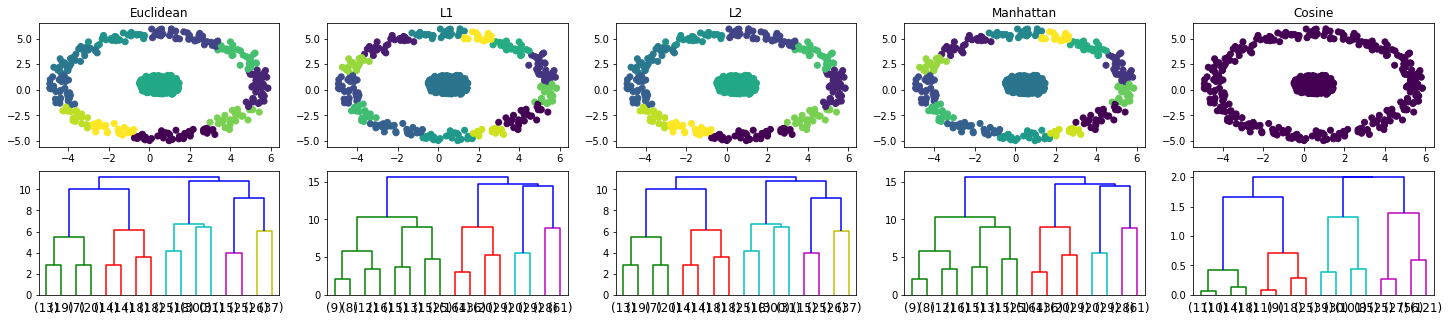

In [9]:
fig = plt.figure(figsize=[25, 5])

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='complete', affinity='euclidean')
hac = hac.fit(X)
ax = fig.add_subplot(2, 5, 1)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Euclidean')
ax = fig.add_subplot(2, 5, 6)
plot_dendrogram(hac, truncate_mode='level', p=3)

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='complete', affinity='l1')
hac = hac.fit(X)
ax = fig.add_subplot(2, 5, 2)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('L1')
ax = fig.add_subplot(2, 5, 7)
plot_dendrogram(hac, truncate_mode='level', p=3)

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='complete', affinity='l2')
hac = hac.fit(X)
ax = fig.add_subplot(2, 5, 3)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('L2')
ax = fig.add_subplot(2, 5, 8)
plot_dendrogram(hac, truncate_mode='level', p=3)

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='complete', affinity='manhattan')
hac = hac.fit(X)
ax = fig.add_subplot(2, 5, 4)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Manhattan')
ax = fig.add_subplot(2, 5, 9)
plot_dendrogram(hac, truncate_mode='level', p=3)

hac = AgglomerativeClustering(distance_threshold=4, n_clusters=None, linkage='complete', affinity='cosine')
hac = hac.fit(X)
ax = fig.add_subplot(2, 5, 5)
ax.scatter(X[:,0], X[:,1], c=hac.labels_);
ax.set_title('Cosine')
ax = fig.add_subplot(2, 5, 10)
plot_dendrogram(hac, truncate_mode='level', p=3)

Things to note:
* Euclidean and L2 look the same. This is becuase they pretty much are
* L1 and Manhatten look the same, again they pretty much are
* Cosine is very different

Cosine is considering the angles between points, so this gives vastly different results. For this data, cosine really doesn't make sense, but when we're concerned with direction and not magnitude, cosine is really good. Often when comparing high dimensional feature vectors (such as deep net embeddings), cosine distance can be rather useful.